In [1]:
from astropy.io import fits
from astropy import wcs
import wcsaxes
import numpy as np
import aplpy
import pandas
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from scipy import optimize
%matplotlib inline 

from os.path import expanduser


In [2]:
home = expanduser("~")
gc_dir = home + "/Dropbox/GalacticCenter/"

filename_skymap = gc_dir + "fits/release_galactic_skymap.fits"
HDUlist = fits.open(filename_skymap)
HDUlist.info()

# get excess data 
skymap_data, skymap_header = fits.getdata(filename_skymap, header = True)


Filename: /Users/mbuchove/Dropbox/GalacticCenter/fits/release_galactic_skymap.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      17   ()              
1    ExcessSkyMap  ImageHDU        18   (240, 240)   float32   
2    SignificanceSkyMap  ImageHDU        18   (240, 240)   float32   


In [3]:
# world coordinate system 
wcs_SgrA = wcs.WCS(filename_skymap)
wcs_GC = wcs.WCS()
w = wcs.WCS(HDUlist[0].header)

#fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(1, 1, 1, projection = wcs_SgrA)
#wx, wy = w.wcs_pix2world(0,0)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


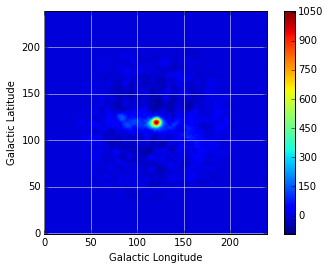

In [4]:
skymap_data_n = np.nan_to_num(skymap_data)

img = plt.imshow(skymap_data_n, origin='lower')
ax = img.axes

ax.grid(color='white', alpha=1, ls='solid')
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
plt.colorbar()


In [5]:
def TwoD_Gaussian(coord, amp, x0, y0, sigma_x, sigma_y, base):
    """simple model of two-dimensional gaussian"""
    x, y = coord
    g = amp*np.exp(-((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2))) + base
    return g.ravel()
# TwoD_Gaussian


In [6]:
nx, ny = skymap_data.shape

# Create x and y indices
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)
coords = x, y


Run fit optimization

In [7]:
guess_SgrA_world = (1000, 0, 0, 0.2, 0.2, 100)
guess_SgrA_pix = (100, 120, 120, 5, 5, 1)
guess_G09_world = (250, 0.08, 0.87, 0.5, 0.5, 50)
#guess_G09_pix = (250,)
#guess_J1745_world = (300)
#guess_J1745_pix = (300)

# Fitting for uncorrelated map, by pixel 
p_opt, p_cov = optimize.curve_fit(TwoD_Gaussian, coords, skymap_data_n.ravel(), p0=guess_SgrA_pix, maxfev=2500)
#p_opt, p_cov = optimize.curve_fit(TwoD_Gaussian, coords_world, excess_data_N.ravel(), p0=guess_world_G09,maxfev=2500)

print(p_opt)
print(p_cov)
#print(y[0:3,8:12])

#init_guess = (1000,120,120,1,1,100)
#p_opt_G09, p_cov_G09 = optimize.curve_fit(TwoD_Gaussian, coords, residual_skymap.ravel(), p0=init_guess_G09)
#p_opt, p_cov = scipy.optimize.curve_fit(TwoD_Gaussian, (x,y), dataN.ravel(), p0=init_guess)

[ 983.54845083  119.57487746  118.80087256    4.53152237    3.5844186
    1.21491344]
[[  9.04719053e+00   8.19847800e-09   8.13801988e-09  -2.08438498e-02
   -1.64865901e-02   3.24445257e-08]
 [  8.19847800e-09   1.92088829e-04  -4.87696073e-16  -3.77514949e-11
    2.21066776e-14  -2.84810875e-12]
 [  8.13801988e-09  -4.87696073e-16   1.20173284e-04   6.91540674e-14
   -2.95840670e-11  -6.69388943e-12]
 [ -2.08438498e-02  -3.77514949e-11   6.91540674e-14   1.92431638e-04
    2.71144581e-07  -3.71982973e-05]
 [ -1.64865901e-02   2.21066776e-14  -2.95840670e-11   2.71144581e-07
    1.20387748e-04  -2.94222562e-05]
 [  3.24445257e-08  -2.84810875e-12  -6.69388943e-12  -3.71982973e-05
   -2.94222562e-05   4.03643717e-03]]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


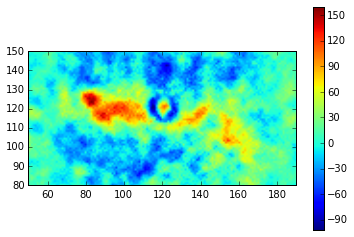

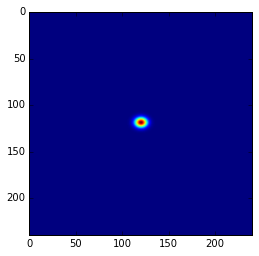

In [8]:
pointSource_excess = TwoD_Gaussian(coords, *p_opt)
#print(pointSource_excess.reshape(240, 240)[115:125, 115:125])
residual_skymap = skymap_data_n - pointSource_excess.reshape(nx, ny)

fig_residual = plt.figure()
plt.axis([50, 190, 80, 150])
plt.imshow(residual_skymap)
plt.colorbar()

#print(residual_skymap[115:125, 115:125])

fig_PS = plt.figure()
plt.imshow(pointSource_excess.reshape(nx, ny))

In [9]:
with open(gc_dir+'/spectralPoints/SgrA_4tels_noPoor_dNdE_TeV.txt') as infile:
    filetext = infile.read()
    linelist = filetext.split(sep='\n')

    for index, line in enumerate(linelist):
        paramlist = line.split()
        if len(paramlist) < 2:
            del linelist[index]
        
    for line in linelist:
        print(line)
    
    
    infile.close()
    
    
lines = list(open(gc_dir+"/spectralPoints/SgrA_4tels_noPoor_dNdE_TeV.txt", "r"))
linesSanitized = map(lambda each:each.strip("\n"), lines)
print(linesSanitized)

Celsius = [39.2, 36.5, 37.3, 37.8]
Fahrenheit = map(lambda x: (float(9)/5)*x + 32, Celsius)
print(*Fahrenheit)


2.498	6.82e-09	5.97e-10
3.959   1.69e-09 	1.08e-10
6.274  	5.42e-10 	4.14e-11
9.943  	1.67e-10 	1.69e-11
15.76   6.00e-11 	7.63e-12
24.98   1.02e-11 	2.59e-12
39.59   1.03e-12 	7.56e-13 

102.56 97.7 99.14 100.03999999999999
